# Improving Performance by Wavelets Denoising

This is continual series of assigment 

You can extend your own code from asssigment M3.2

- Exercise. Wavelet Denoising for Return Prediction Model

# Exercise. Wavelets Denoising for Return Prediction Model


#### Requirements
- Apply Wavelets Denoising on the Return of Cryptocurrency
- Predict Denoised Future Return of Crypotocurrency 
- Evaluate the Performance

#### Procedures
- Preprocessing
  1. Data Import and Create Balanced Panel
  2. Denoising Return and Create Target Variable
  3. Train / Test Split
  4. Create Sequences
  
- Training / Predicting Model
  1. Model Build
  2. Model Train
  3. Prediction
  4. Evaluation

### 1. Data Import and Create Balanced Panel

In [1]:
!pip install pywavelets

In [0]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
DATA_PATH = "/content/gdrive/My Drive/Lecture/StudyPie/Data/"

In [5]:
!ls "/content/gdrive/My Drive/Lecture/StudyPie/Data/"

256x2-CNN.model  crypto_data.zip  M2_1_y.pickle  PetImages.zip
CoinOne		 log		  __MACOSX	 simple_rnn_model.h5
crypto_data	 M2_1_X.pickle	  PetImages


In [0]:
# Unzip Data
# It will take more than 5 min
import zipfile
import io

zf = zipfile.ZipFile(DATA_PATH+"crypto_data.zip", "r")
zf.extractall(DATA_PATH)

In [0]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "LTC-USD"

## Preprocessing

### 1. Data Import and Create Balanced Panel

In [8]:
import pandas as pd
from sklearn import preprocessing 

main_df = pd.DataFrame() # begin empty

ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]  # the 4 ratios we want to consider

for ratio in ratios:  # begin iteration
  print(ratio)
  dataset = DATA_PATH+f'crypto_data/{ratio}.csv'  # get the full path to the file.
  df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file

  # rename volume and close to include the ticker so we can still which close/volume is which:
  df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)

  df.set_index("time", inplace=True)  # set time as index so we can join them on this shared time
  df = df[[f"{ratio}_close", f"{ratio}_volume"]]  # ignore the other columns besides price and volume

  if len(main_df)==0:  # if the dataframe is empty
      main_df = df  # then it's just the current df
  else:  # otherwise, join this data to the main one
      main_df = main_df.join(df)

main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)
print(main_df.head())  # how did we do??

BTC-USD
LTC-USD
BCH-USD
ETH-USD
            BTC-USD_close  BTC-USD_volume  LTC-USD_close  LTC-USD_volume  \
time                                                                       
1528968720    6487.379883        7.706374      96.660004      314.387024   
1528968780    6479.410156        3.088252      96.570000       77.129799   
1528968840    6479.410156        1.404100      96.500000        7.216067   
1528968900    6479.979980        0.753000      96.389999      524.539978   
1528968960    6480.000000        1.490900      96.519997       16.991997   

            BCH-USD_close  BCH-USD_volume  ETH-USD_close  ETH-USD_volume  
time                                                                      
1528968720     870.859985       26.856577      486.01001       26.019083  
1528968780     870.099976        1.124300      486.00000        8.449400  
1528968840     870.789978        1.749862      485.75000       26.994646  
1528968900     870.000000        1.680500      486.00000    

### 2. Create Target Variable

In [0]:
import pywt
import numpy as np
from statsmodels.robust import mad
 
def waveletSmooth(x, wavelet="haar", level=1):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # calculate a threshold
    sigma = mad(coeff[-level])
    
    # changing this threshold also changes the behavior,
    # but I have not played with this very much
    uthresh = sigma * np.sqrt( 2*np.log(len(x)))
    coeff[1:] = (pywt.threshold( i, value=uthresh, mode="soft") for i in coeff[1:])
    
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec(coeff, wavelet, mode="per" )
    return y

In [0]:
import numpy as np
from collections import deque

currency_targets = ["BTC"]

for currency_target in currency_targets:
  main_df[currency_target+'-USD-TARGET'] = main_df[currency_target+'-USD_close'].shift(-FUTURE_PERIOD_PREDICT )

  # scale up, you can do any other scaling methods!
  # how can we improve this part?
  # hint: reduce noise of future return  
  main_df[currency_target+'-USD-TARGET-RETURN'] = (main_df[currency_target+'-USD-TARGET']-main_df[currency_target+'-USD_close'])/main_df[currency_target+'-USD_close']*100 # scale up
  main_df = main_df[np.isfinite(main_df[currency_target+'-USD-TARGET-RETURN'])]
  
  # we shouldn't use future information
  # to figure out whether it's on peak or troughs
  denoised_data = []
  queue_wavelets = deque(maxlen = SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in main_df[currency_target+'-USD-TARGET-RETURN'].tolist():  # iterate over the values
      queue_wavelets.append(i)  # store all but the target
      if len(queue_wavelets) == SEQ_LEN:  # make sure we have 60 sequences!
          denoised_data.append(waveletSmooth(np.array(queue_wavelets), wavelet="haar", level=1)[-1])  # append those bad boys!

  main_df[currency_target+'-USD-TARGET-RETURN'] = [None]*(SEQ_LEN-1)+denoised_data
  
  main_df = main_df[np.isfinite(main_df[currency_target+'-USD-TARGET-RETURN'])]    
  main_df.drop(columns=[currency_target+'-USD-TARGET'], inplace=True)

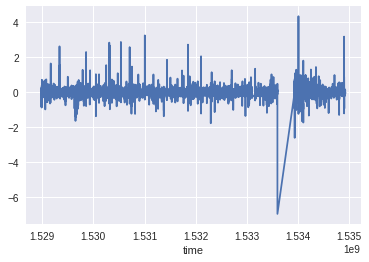

In [39]:
main_df[currency_target+'-USD-TARGET-RETURN'].plot()

In [0]:
from sklearn import preprocessing  # pip install sklearn ... if you don't have it!
main_df.fillna(main_df.mean(), inplace=True)

In [41]:
main_df.head()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,BCH-USD_close,BCH-USD_volume,ETH-USD_close,ETH-USD_volume,BTC-USD-TARGET-RETURN
time,,,,,,,,,
1528975800,6519.990234,2.841977,97.360001,257.988220,874.799988,24.195404,487.809998,39.683456,0.021613
1528975860,6519.990234,2.462582,97.410004,864.196167,874.099976,8.295891,488.000000,15.820030,0.029480
1528975920,6519.990234,0.972875,97.370003,90.964149,875.409973,4.955900,487.570007,14.633918,0.032878
1528975980,6522.970215,11.705941,97.470001,347.946838,874.989990,4.240500,488.000000,42.496407,0.040992
1528976040,6522.959961,5.288531,97.519997,130.761002,874.979980,0.094700,487.989990,98.885689,0.023502


### 3. Train / Test Split

In [0]:
times = sorted(main_df.index.values)  # get the times
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]  # get the last 5% of the times

test_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%

### 4. Create Sequences

In [0]:
from sklearn import preprocessing  # pip install sklearn ... if you don't have it!
from collections import deque
import random
import numpy as np

def sequence_generator(main_df, SEQ_LEN, suffle=True,seed=101):
    
  sequential_data = []  # this is a list that will CONTAIN the sequences
  queue = deque(maxlen = SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

  for i in main_df.values:  # iterate over the values
      queue.append([n for n in i[:-1]])  # store all but the target
      if len(queue) == SEQ_LEN:  # make sure we have 60 sequences!
          sequential_data.append([np.array(queue), i[-1]])  # append those bad boys!

  if suffle == True:
      random.seed(seed)
      random.shuffle(sequential_data)  # shuffle for good measure.

  X = []
  y = []

  for seq, target in sequential_data:  # going over our new sequential data
      X.append(seq)  # X is the sequences
      y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

  return np.array(X), y  # return X and y...and make X a numpy array!

In [0]:
train_x, train_y = sequence_generator(main_df , SEQ_LEN, suffle=True, seed=101)
test_x, test_y = sequence_generator(test_main_df , SEQ_LEN, suffle=True, seed=101)

In [45]:
print(train_x.shape, len(train_y))
print(test_x.shape, len(test_y))

(85601, 60, 8) 85601
(4449, 60, 8) 4449


## Return Prediction Model

### 1. Model Build

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM,\
CuDNNLSTM, BatchNormalization, Flatten, Activation

def ex2_models(input_dim, output_dim):

  # you can try your own model!
  
  L1 = 256  # 256
  L2 = 256  # 256
  L3 = 32  # 32

  model = Sequential()
  
  model.add(CuDNNLSTM(L1, input_shape=input_dim, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

  model.add(CuDNNLSTM(L2, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())

  model.add(CuDNNLSTM(L3))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())


  model.add(Flatten())
  model.add(Dense(output_dim))
  model.add(Activation('linear'))

  model.compile(optimizer=tf.train.AdamOptimizer(0.001),
            loss='mean_squared_error')

  return model

### 2. Model Train

In [0]:
model2 = ex2_models(train_x.shape[1:], 1)

In [0]:
BATCH_SIZE = 64 
NUM_ITERATIONS = 10

hist2 = model2.fit(train_x, train_y, 
              validation_split=0.2,                   
              batch_size = BATCH_SIZE,
              epochs = NUM_ITERATIONS)

Train on 68480 samples, validate on 17121 samples
Epoch 1/10
23168/68480 [=========>....................] - ETA: 39s - loss: 0.2235

### 3. Prediction

In [29]:
predictions = model2.predict(test_x)

# Score model
score = model2.evaluate(test_x, test_y,
                       verbose=0)

print('Test loss:', score) # this is mean_squared_error 

Test loss: 1832023.1684261037


### 4. Evaluation

1. Comparing Accuracy both Train and Validation set data
  - Compare loss according to the below materials
  - Visualize training history  
  - Check genelarization of your model
  - Refer
    - https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-1-2-correct-time-series-forecasting-backtesting-9776bfd9e589
  - Visualization Hint
    - https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [30]:
# list all data in history
print(hist2.history.keys())

dict_keys(['val_loss', 'loss'])


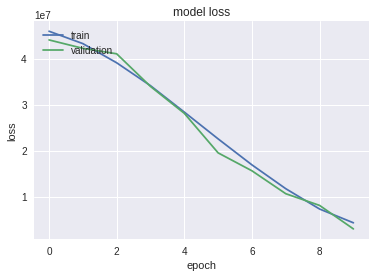

In [31]:
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

    
2. Measure Model Accuracy for Continuous Value
  - Change Your Prediction Values into Up / Down Binary Variable
  - After then do the same things as in Exercise 1
    - Accuracy, Recall, F1 Score based on Confusion Matrix
    - Refer definition of each scores
      - Confusion matrix https://en.wikipedia.org/wiki/Confusion_matrix
      - Confusion matrix in Korean https://datascienceschool.net/view-notebook/731e0d2ef52c41c686ba53dcaf346f32/
  - Hint
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    - http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html      

In [0]:
predictions_binary = [1 if prediction >0 else 0 for prediction in predictions]
test_y_binary = [1 if y >0 else 0 for y in test_y]

In [33]:
from sklearn.metrics import classification_report
print(classification_report(predictions_binary, test_y_binary))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00      4689

avg / total       1.00      1.00      1.00      4689



In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(predictions_binary, test_y_binary))

[[4689]]


3. Measure Test Set Return based on the Simplest Strategy
  - Condition
    - Initial budget = 100
  - Strategy
    - If we predict up, then buy or hold (if we already bought)
    - If we predict down, then sell (if we already bought) or do nothing 
  - Draw your return


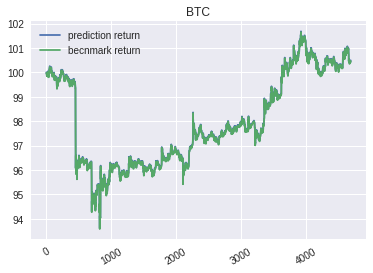

In [35]:
import matplotlib.pyplot as plt

for currency_target in currency_targets:
    bechmark_return = 100
    bechmark_return_history = []

    prediction_return = 100
    prediction_return_history = []

    buy_price = 0
    sell_price = 0
    
    hold = False
    
    test_main_df[currency_target+'-USD-FUTURE_close'] = test_main_df[currency_target+'-USD_close'].shift(-1)
    test_main_df[currency_target+'-USD-RETURN'] = (test_main_df[currency_target+'-USD-FUTURE_close'] 
                                                                - test_main_df[currency_target+'-USD_close'])/test_main_df[currency_target+'-USD_close']
    
    for prediction, (i, r) in zip(predictions, test_main_df.iloc[SEQ_LEN-1:].iterrows()):
        
        if hold == True:
            prediction_return = prediction_return*(1+r[currency_target+'-USD-RETURN'])  
            
        bechmark_return = bechmark_return*(1+r[currency_target+'-USD-RETURN'])
        bechmark_return_history.append(bechmark_return)
        prediction_return_history.append(prediction_return)

        if prediction >0:
            hold = True
        else: 
            hold = False
    
    plt.title(currency_target)
    plt.plot(prediction_return_history, label = 'prediction return')    
    plt.plot(bechmark_return_history, label = 'becnmark return')
    plt.xticks(rotation=30)
    plt.legend()